In [2]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for data augmentation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
# checking the count of images present in the dataset
total_images = 0
root_dir = "/kaggle/input/dataset-1/train"
for i in os.listdir(root_dir):
    print("Total no. of images present in",i,"are:",len(os.listdir(root_dir+"/"+i)))
    total_images+=len(os.listdir(root_dir+"/"+i))


Total no. of images present in Sample060 are: 40
Total no. of images present in Sample014 are: 40
Total no. of images present in Sample011 are: 40
Total no. of images present in Sample041 are: 40
Total no. of images present in Sample025 are: 40
Total no. of images present in Sample049 are: 40
Total no. of images present in Sample010 are: 40
Total no. of images present in Sample017 are: 40
Total no. of images present in Sample032 are: 40
Total no. of images present in Sample005 are: 40
Total no. of images present in Sample034 are: 40
Total no. of images present in Sample031 are: 40
Total no. of images present in Sample003 are: 40
Total no. of images present in Sample009 are: 40
Total no. of images present in Sample002 are: 40
Total no. of images present in Sample052 are: 40
Total no. of images present in Sample035 are: 40
Total no. of images present in Sample018 are: 40
Total no. of images present in Sample004 are: 40
Total no. of images present in Sample020 are: 40
Total no. of images 

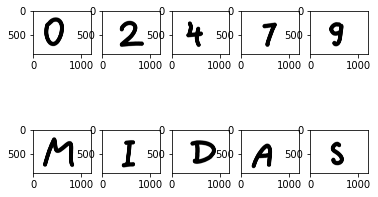

In [3]:
# plotting various images from the dataset.
plt.subplot(2, 5, 1)
plt.imshow(plt.imread(root_dir+"/Sample001/img001-001.png"))

plt.subplot(2,5,2)
plt.imshow(plt.imread(root_dir+"/Sample003/img003-002.png"))

plt.subplot(2,5,3)
plt.imshow(plt.imread(root_dir+"/Sample005/img005-001.png"))

plt.subplot(2,5,4)
plt.imshow(plt.imread(root_dir+"/Sample008/img008-002.png"))

plt.subplot(2,5,5)
plt.imshow(plt.imread(root_dir+"/Sample010/img010-002.png"))

plt.subplot(2,5,6)
plt.imshow(plt.imread(root_dir+"/Sample023/img023-001.png"))

plt.subplot(2,5,7)
plt.imshow(plt.imread(root_dir+"/Sample019/img019-001.png"))

plt.subplot(2,5,8)
plt.imshow(plt.imread(root_dir+"/Sample014/img014-001.png"))

plt.subplot(2,5,9)
plt.imshow(plt.imread(root_dir+"/Sample011/img011-001.png"))

plt.subplot(2,5,10)
plt.imshow(plt.imread(root_dir+"/Sample029/img029-002.png"))


plt.show()

(900, 1200, 3)


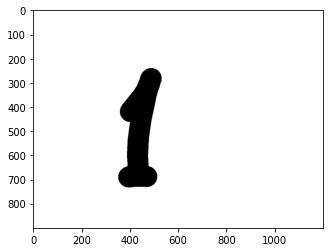

In [4]:
img = plt.imread(root_dir+"/Sample002/img002-001.png")
print(img.shape)
plt.imshow(img)
plt.show()

In [5]:
# checking the min and max pixel value. It is a good practise to normalize the pixel values
print("minimum pixel value of image:",img.min())
print("maximum pixel value of image:",img.max())

maximum pixel value of image: 1.0
minimum pixel value of image: 0.0


Conclusions of data analysis:

1. For all the 62 categories we only have 40 images per category. Depending on the performance of our model, we might need to apply data augmentation techniques to achieve more accuracy on test set and reduce overfitting.
2. Initially, the images are of the dimension 900x1200x3. As we can see from the random samples we have printed, there is a lot of unnceccsary extra space in the images. This padding(white space) is mostly on the right side of the image. We can remove this extra space which would improve our computation speed.
3. Normalizing the pixel values ensures that input parameters have a uniform distribution and thus helps in faster convergence.[1] Since, these values are already normalized we don't need to modify the pixel values. 
4. Large image size implies added noise and variance that the neural network has to deal with. Which in turn also means that we would need more layers to achieve a greater accuracy. [2]
5. Since most of the input features are alligned towards the center, we can take a square crop of the center and then scale down the image. This would also help us to tackle with problems mentioned in point 2 and point 4.[3]
6. Using downsized images helps to reduce the error rate in a small amount [8]

It would optimal to apply the above transformations on the image while loading it into the numpy array. Another alternate would have been to either overwrite the images with their transformed version or create a new folder. Both of these methods are not efficient as we might end up with either loosing the data or unneccessarily increase the storage requirement.

## Loading the data and assigning the labels

For model training, we would require a list(X) in which our images are stored and another list(y) in which the class of respective images are stored.
Since the images are organised folder wise, we need to access the images from these folder append it into list X and subsequently append it's class to the list Y.

Data transformations, that were mentioned above, will be applied after storing the data into the list

Since retrieving data and transforming it is more accessible through list I have chosen to use that. The datatype will be changed to a numpy array after applying all the transformations.


Outline of stored data:


*   Sample001-Sample010: digits from 0 to 9
*   Sample011-Sample036: upper case alphabets a-z
*   Sample037-Sample062: small case alphabets A-Z

As storing categorical labels('a','M', 'z') is not desirable. I chose to label the classes from 0 to 61 just like in the directory structure:
* 0-9 digits will be given the label of 0-9
* A-Z alphabets will be given the label from 10-36
* a-z alphabets will be given the label from 37-62.

* I  have kept a label var to keep a count of the labels

Note: The assigned labels will be one less than folder number given in dir struct. for e.g M has been store in the folder Sample023 but I have assigned it a label of 22.

In [6]:
X = [] #list for storing image arrays
y = [] # list for storing the image labels

In [7]:
# storing digits from 0 to 9 first
label = 0 # count will be used to store the respective label
for i in sorted(os.listdir(root_dir)): 
    for j in os.listdir(root_dir + "/" + i): # accessing the folder
        X.append(cv2.imread(root_dir+"/" + i + "/" + j)) # accessing images in the respective folder
        y.append(label)

    label+=1 #incrementing the count/label 
    if(label==10): break # if all the images from 0 to 9 have been stored then break out of the loop
    

400
400
0 2 9


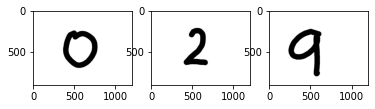

In [8]:
# sanity check
print(len(X))
print(len(y))

plt.subplot(1,3,1)
plt.imshow(X[0])

plt.subplot(1,3,2)
plt.imshow(X[80])

plt.subplot(1,3,3)
plt.imshow(X[399])


print(y[0],y[80],y[399])

In [9]:
# storing upper case alphabets (A-Z)
count = 65  #ascii value of A. We'll go till 90 i.e ascii value of Z

for i in sorted(os.listdir(root_dir))[10:]: #accessing folder after Sample010 i.e folders after the digit 9
    for j in os.listdir(root_dir + "/" + i):
        X.append(cv2.imread(root_dir+"/" + i + "/" + j))
        y.append(label)
        
    count+=1
    label+=1
    if(count==78): break #if we have accessed the Z folder then break the loop      

In [10]:
count = 78
for i in sorted(os.listdir(root_dir))[23:]: #accessing folder after Sample010 i.e folders after the alphabet m
    for j in os.listdir(root_dir + "/" + i):
        X.append(cv2.imread(root_dir+"/" + i + "/" + j))
        y.append(label)
        
    count+=1
    label+=1
    if(count==91): break #if we have accessed the Z folder then break the loop 

1440
1440
10 22 23 35


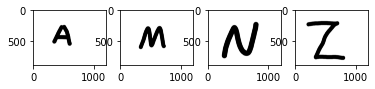

In [11]:
# sanity check
print(len(X))
print(len(y))

plt.subplot(1,4,1)
plt.imshow(X[401])

plt.subplot(1,4,2)
plt.imshow(X[880])

plt.subplot(1,4,3)
plt.imshow(X[959])


plt.subplot(1,4,4)
plt.imshow(X[1439])




print(y[401],y[880], y[959],y[1439])

In [12]:
# storing lower case alphabets (a-z)
count = 97  #ascii value of A. We'll go till 122 i.e ascii value of z

for i in sorted(os.listdir(root_dir))[36:]:#accessing folder after Sample036 i.e folders after the upper case alphabet Z
    for j in os.listdir(root_dir + "/" + i):        
        X.append(cv2.imread(root_dir+"/" + i + "/" + j))
        y.append(label)
            
        
    count+=1
    label+=1
    if(count==110): break #if we have accessed the z folder then break the loop  


In [13]:
count = 110
for i in sorted(os.listdir(root_dir))[49:]: #accessing folder after Sample048 i.e folders after the lower case alphabet m 
    for j in os.listdir(root_dir + "/" + i):
        X.append(cv2.imread(root_dir+"/" + i + "/" + j))
        y.append(label)
    
        
    count+=1
    label+=1
    if(count==123): break #if we have accessed the z folder then break the loop     

2480
2480
36 48 49 61


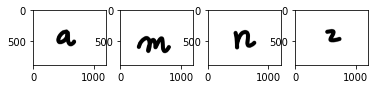

In [14]:
#sanity check
print(len(X))
print(len(y))

plt.subplot(1,4,1)
plt.imshow(X[1440])

plt.subplot(1,4,2)
plt.imshow(X[1959])

plt.subplot(1,4,3)
plt.imshow(X[1960])


plt.subplot(1,4,4)
plt.imshow(X[2479])




print(y[1440],y[1959], y[1960],y[2479])

Now, that we have organised our images, we'll apply various image transformations on the image for efficienct storage and computation.
As mentioned earlier, we'll take a centre square crop of the images. This is allow us to remove unneccessary padding, help the CNN to focus on important features and decrease our computation resources.

(224, 224, 3)
<class 'numpy.ndarray'>


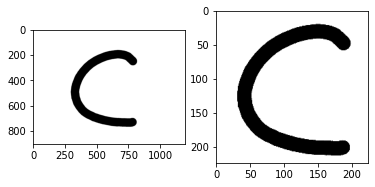

In [15]:
'''
For testing applying the above mentioned transformations to a single image
(to keep things simple for me, I'll crop the images by taking an approximate guess :P)
We will also have to reduce the size of the image because the current size will consume a lot of resources

'''

#test_img = X[60]
# modified_img = cv2.cvtColor(X[60], cv2.COLOR_BGR2GRAY)
# modified_img = modified_img[100:800,200:900]



original_img = X[480]

# modified_img = cv2.cvtColor(original_img[100:800,200:900], cv2.COLOR_BGR2GRAY)
modified_img = original_img[100:800,200:900]

scale_percent = 32
width = int(modified_img.shape[1] * scale_percent / 100)
height = int(modified_img.shape[0] * scale_percent / 100)

dsize = (width, height)
modified_img = cv2.resize(modified_img, dsize)
modified_img = np.resize(modified_img,(modified_img.shape[0],modified_img.shape[1],3))

print(modified_img.shape)
print(type(modified_img))


plt.subplot(1,2,1)
plt.imshow(original_img)

plt.subplot(1,2,2)
plt.imshow(modified_img,cmap='gray')


plt.show()

In [16]:
# Applying data transformation to all the images
for i in range(len(X)):
    # X[i] = cv2.cvtColor(X[i][100:800,200:900], cv2.COLOR_BGR2GRAY)
    X[i] = X[i][100:800,200:900]
    scale_percent = 32
    width = int(X[i].shape[1] * scale_percent / 100)
    height = int(X[i].shape[0] * scale_percent / 100)

    dsize = (width, height)

    X[i] = cv2.resize(X[i], dsize)
    X[i] = np.resize(X[i],(X[i].shape[0],X[i].shape[1],3))


(224, 224, 3)


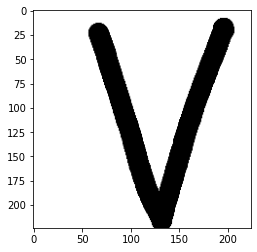

In [17]:
print(X[1241].shape)
plt.imshow(X[1241],cmap="gray")
plt.show()

In [18]:
# sanity check (checking if shape of the image has changed or not)
import random
for i in range(5):#checking for 5 random images
    print(X[random.randint(0,2479)].shape)


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


## Data Augmentation

A dataset of 2480 images might lead to overfitting. Thus, to increase the dataset we apply some data augmentation techniques. 
* Various studies[8][10] have shown that applying data transformations like rotation, translating by width and height shifts and shearing prove to be effective in helping to achieve better generalization.
* We cannot use techniques like flipping as it would change the context.
* We can also apply more complex things like generating images using encoder-decoder networks or GANs.
* To apply the above mentioned data augmentation techniques, I have used the keras library of ImageDataGenerator. It creates various augmentations of the images in every epoch. This part is implemented while model training.


## ---------- END OF DATA PREPROCESSING ----------

In [24]:
# splitting the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.3)

In [25]:
# creating labels
from sklearn.preprocessing import LabelBinarizer
LB = LabelBinarizer()
y_train = LB.fit_transform(y_train)
y_test = LB.fit_transform(y_test)

In [26]:
# modifiying the type and shape of input images.
X_train = np.array(X_train)
X_train = X_train.reshape(-1,224,224,3)

X_test = np.array(X_test)
X_test = X_test.reshape(-1,224,224,3)

In [27]:
# sanity check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1736, 224, 224, 3)
(744, 224, 224, 3)
(1736, 62)
(744, 62)


Model building. These were the factors that I considered while model building and training:

1. Conventional and famous architectures like LeNet, AlexNet and VGG16 have shown high performance on various image classification problems. These models use consequent layers of convolution and pooling pair while increasing the number of filters in each subsequent layer. They finally flatten the output and send into a 3/4 dense layers taking the output from dense layer with softmax activation function. I have used a similar structure for classifying images to the 62 categories.

2. There is a lot of difference in the images in part1 (1200x700) and in part2/part3 (28x28). We cannot include many layers of convolution and max pooling  as it would drastically downsize the images of size 28x28 and make this model unfit to be re-trained on those images. On the contray, we would want to include more convolution so that we could maximize the feature extraction of the 1200x700 images. Therefore, we have to create a balance so that we could efficiently manage both sizes of images. Considering I have chosen to limit the 3 convolution and max pooling layers.

3. Conventional architectures like AlexNet and VGG16 use a kernel size of 3x3 and have multiple convolution layers. Since, the model has only 3 layers of convolution it creates a problem. This is because the units after flattening becomes around 40 lakh and it becomes difficult to condense this information into a dense layer of limited units. If we use a kernel of 3x3 then we would loose a lot of information upon sending it to a dense layer. Therefore, I have used a bigger kernel size at the begining. 

4. Again, the difference in image size is the reason why I have used a limited number of dense layers with limited number of units in them.

5. Since we have a limited number of training images, the model has a high probability of overfitting the data. To prevent this I have used dropout layers in between.

6. For preventing the model from getting stagnated in the local minima, I have used the keras's ReduceLROnPlateau library. This monitors the val_loss and changes the learning rate of the model accordingly.

In [6]:
# Number of classes.
num_classes = 62

In [8]:
# initializing the model
model = Sequential()

# layer 1
model.add(Conv2D(filters = 64, kernel_size = (5, 5), strides = 1, activation = 'relu', input_shape = (224, 224, 3)))

# layer 2
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.2))

# layer 3
model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation = 'relu'))

# layer 4
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# layer 5
model.add(Conv2D(filters = 256, kernel_size = (2, 2), strides = 1, activation = 'relu'))
# layer 6
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# layer 7
model.add(Flatten())

# layer 8
model.add(Dense(512, activation = 'relu', use_bias=False))
model.add(Dropout(0.2))

# layer 9
model.add(Dense(256, activation = 'relu', use_bias=False))
model.add(Dropout(0.2))

# layer 10
model.add(Dense(128, activation = 'relu', use_bias=False))

# output layer
model.add(Dense(num_classes, activation = 'softmax'))     

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 33, 256)      

In [40]:
# initializing keras object to dynamically change the learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2, mode='min')

In [41]:
# Image augmentation object
datagen = ImageDataGenerator(width_shift_range = (-10,10),           
                             height_shift_range = (-10,10),
                             rotation_range = 10)

# compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# checkpoint
checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
                                            filepath=checkpoint_filepath,
                                            save_weights_only=False,
                                            monitor='accuracy',
                                            mode='max',
                                            save_best_only=True)

# training the model
hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32, epochs = 100, callbacks=[reduce_lr],validation_data = (X_test,y_test))

Epoch 1/100
54/54 [==============================] - 18s 321ms/step - loss: 135.9218 - accuracy: 0.0126 - val_loss: 4.1271 - val_accuracy: 0.0228
Epoch 2/100
54/54 [==============================] - 16s 307ms/step - loss: 4.1114 - accuracy: 0.0208 - val_loss: 4.0444 - val_accuracy: 0.0524
Epoch 3/100
54/54 [==============================] - 17s 319ms/step - loss: 4.0210 - accuracy: 0.0430 - val_loss: 3.8035 - val_accuracy: 0.0981
Epoch 4/100
54/54 [==============================] - 17s 305ms/step - loss: 3.8424 - accuracy: 0.0745 - val_loss: 3.4591 - val_accuracy: 0.1492
Epoch 5/100
54/54 [==============================] - 18s 324ms/step - loss: 3.6318 - accuracy: 0.1227 - val_loss: 2.9957 - val_accuracy: 0.2446
Epoch 6/100
54/54 [==============================] - 17s 305ms/step - loss: 3.2569 - accuracy: 0.1757 - val_loss: 2.6259 - val_accuracy: 0.3293
Epoch 7/100
54/54 [==============================] - 17s 320ms/step - loss: 2.9555 - accuracy: 0.2217 - val_loss: 2.3109 - val_accurac

54/54 [==============================] - 18s 324ms/step - loss: 0.7516 - accuracy: 0.7773 - val_loss: 1.1082 - val_accuracy: 0.7083
Epoch 58/100
54/54 [==============================] - 17s 314ms/step - loss: 0.7889 - accuracy: 0.7477 - val_loss: 1.1082 - val_accuracy: 0.7083
Epoch 59/100
54/54 [==============================] - 18s 321ms/step - loss: 0.7168 - accuracy: 0.7950 - val_loss: 1.1082 - val_accuracy: 0.7083
Epoch 60/100
54/54 [==============================] - 17s 312ms/step - loss: 0.7005 - accuracy: 0.7796 - val_loss: 1.1082 - val_accuracy: 0.7083
Epoch 61/100
54/54 [==============================] - 17s 316ms/step - loss: 0.7841 - accuracy: 0.7633 - val_loss: 1.1082 - val_accuracy: 0.7083
Epoch 62/100
54/54 [==============================] - 17s 314ms/step - loss: 0.7753 - accuracy: 0.7666 - val_loss: 1.1082 - val_accuracy: 0.7083
Epoch 63/100
54/54 [==============================] - 17s 319ms/step - loss: 0.7495 - accuracy: 0.7720 - val_loss: 1.1082 - val_accuracy: 0.708

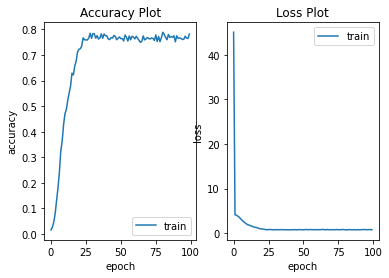

In [43]:
# plotting the training and accuracy of the model

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title("Accuracy Plot")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'])

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title("Loss Plot")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])

plt.show()

In [44]:
# accuracy and loss of the model

score = model.evaluate(X_test, y_test)
print("Testing loss : ", score[0])
print("Testing accuracy : ", score[1])

24/24 [==============================] - 0s 12ms/step - loss: 1.1082 - accuracy: 0.7083
Testing loss :  1.1081892251968384
Testing accuracy :  0.7083333134651184


In [45]:
# saving the model
model.save('./part1_model')

In [ ]:
# zipping the output files
!tar -zcvf outputname.tar.gz /kaggle/working

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/outputname.tar.gz
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/part1_model/
/kaggle/working/part1_model/assets/
/kaggle/working/part1_model/variables/
/kaggle/working/part1_model/variables/variables.index
/kaggle/working/part1_model/variables/variables.data-00000-of-00001


## Learning logs:
1. It is to better to split data and append data in batches. Otherwise, we might encounter a runtime timeout error.

2. It is more optimal to use cv2 while reading the images. If we use up more than 12GB of RAM. By reading images through cv2 the RAM utilization by around 4GB. This happens because CV2 reads and stores the image as a numpy array rather than a list.

3. By observing various samples we can can conclude that most of the white space is towards the right of the images. A naive way of reducing the images would be to simply crop this space out by making an approximate guess. However, if we want an accurate analysis we can take the mean and stardard deviation across each pixel of all the images and then reduce the image accordingly.[2] 

4. Taking input a batch of 700x700 images requires heavy computational resources and we eventually run out of GPU/RAM resource. Thus it is better to scale down images. I have decided to scale down to 20%

5. I wanted to try our some conventional architectures like VGG16, GoogleNet etc. These are deep neural networks significantly scale down by applying various conv and pooling layers. Since, these networks require a input_size of 224x224 I decided to scale down the input images to around 256x256. (approx 36% of the original image). This approach, though quite obvious, fails on the grayscale as these architectures were made to work on RGB images. These architectures do more harm than good. These models gave an accuracy of around 0.04 and a categorical cross entropy loss of around 4.01 .However, since I would want to build some deep neural networks I will still stick to the image size of 256x256x1. (Quite stupid of me to think that these conventional architectures would work on grayscale images).

6. I tried to apply batch normalization. Batch Normalization allows us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout [7]. However, in our case it significantly reduces the training and testing accuracy. This might because we have a large number of classes to predict. Applying batch normalization layer restricts parameters, thus increasing hindering 


7. At the end, a simple 3 layer CNN architecture with dropout layers  gave me the best result on this current dataset of 2480 images. On training on 20 epochs it gave a training accuracy of  0.99 and training loss of 0.02084. On the small testing set it gave a accuracy of 0.22 and 8.22. Making a few minor changes would not help the results. As the data is quite small, the models quickly overfit the data and eventually perform badly on test sets. Thus, for better performance we have to apply data augmentation techniques to produce a considerable dataset to train on.

8. Augmenting the data by using ImageDataGenerator API of keras helps us to improve the testing accuracy to more than 57% in 50 epochs. The test accuracy tends to saturate around 62%. This was maximum accuracy that I could achieve on a single channel images.

9. Using a 3 channel image as the input gives better results. To prevent overfitting I have to add dropout layers

10. A deep nueral networks fails as images in the mnist are very small. Therefore, I have to consider the shape of those images as well.


Citations:
1. [1]: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/#:~:text=Normalize%20Pixel%20Values,-For%20most%20image&text=As%20such%20it%20is%20good,images%20can%20be%20viewed%20normally.
2. [2]: https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258#:~:text=Normalizing%20image%20inputs%3A%20Data%20normalization,faster%20while%20training%20the%20network.
3. [3]: https://datascience.stackexchange.com/questions/16601/reason-for-square-images-in-deep-learning
4. [4]: https://towardsdatascience.com/a-hitchhiker-guide-to-python-numpy-arrays-9358de570121#:~:text=with%20mathematical%20calculations.-,1.,further%20optimisation%20of%20the%20code.
5. [5]: https://towardsdatascience.com/a-guide-for-building-convolutional-neural-networks-e4eefd17f4fd
6. [6] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. Journal of Machine Learning Research, 15, 1929–1958.
7. [7] Ioffe, Sergey, and Christian Szegedy. “Batch normalization: Accelerating deep network training by reducing internal covariate shift.” arXiv preprint arXiv:1502.03167 (2015).
8. [8] Alonso-Weber, Juan Manuel, et al. "Handwritten digit recognition with pattern transformations and neural network averaging." International Conference on Artificial Neural Networks. Springer, Berlin, Heidelberg, 2013.
9. [9] Garcia de Alford, Adriana Solange, et al. "Reducing Age Bias in Machine Learning: An Algorithmic Approach." SMU Data Science Review 3.2 (2020): 11.
10. [10] Gu, Shanqing, Manisha Pednekar, and Robert Slater. "Improve Image Classification Using Data Augmentation and Neural Networks." SMU Data Science Review 2.2 (2019): 1.